# Create a synthetic database

## Set options

In [150]:
# Import the sampler module
from os import path
from src.sampler import SinSampler


In [12]:
# Data options
save_repo = '/home/younesz/Desktop/SUM'
data_type = 'single'
epoch_length = 180 
noise_level = 1.5 # times sinus variance
frequency_range = (20, 40) # nb of oscillations within the epoch
amplitude_range = (49, 50) # has to be narrower than frequency range

In [14]:
# Make database
sampler = SinSampler(data_type, epoch_length, noise_level, frequency_range, amplitude_range, save_repo)


In [25]:
# Generate an epoch
epoch = sampler.sample()[0]


In [53]:
import matplotlib.pyplot as plt
%matplotlib inline 

def plot_epoch(epoch, color='b'):
    plt.plot(epoch, color=color);
    plt.xlabel('Time (hours)');
    plt.ylabel('Amplitude (USD)');

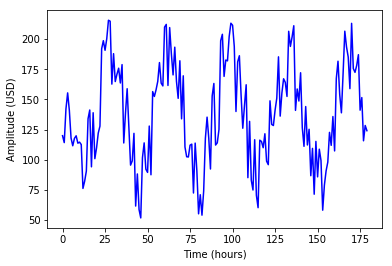

In [54]:
# Display data
plot_epoch(epoch)

# Make the environment

## Set options

In [82]:
# State options
state_size = 32 # samples
time_difference = True
wavelet_channels = 0 # No wavelet transform

In [83]:
# Action options
action_range = [-1,1]
action_labels = ['short-all', 'short-half', 'hold', 'long-half', 'long-all'] 
""" Note: from the action labels, the environment figures out how many different actions the agent can take 
and splits the action range accordingly - in this case the agent can select the actions 0 to 4 and the environment
interprets them as [-1, -0.5, 0, 0.5, 1]. If only one label is provided, the action is continuous by default """


' Note: from the action labels, the environment figures out how many different actions the agent can take \nand splits the action range accordingly - in this case the agent can select the actions 0 to 4 and the environment\ninterprets them as [-1, -0.5, 0, 0.5, 1]. If only one label is provided, the action is continuous by default '

In [84]:
# Reward options
open_cost = 3 # percentage fee for each buy transaction

In [85]:
# Make the environment
from src.emulator import Market
env = Market(sampler, state_size, open_cost, time_difference=time_difference, 
             wavelet_channels=wavelet_channels, action_range=action_range, action_labels=action_labels)

## Interact with the environment

In [136]:
# Get state
state, valid_actions = env.reset()

'The red trace is the state observed by the agent, which is the differenciated and normalized price (blue trace)'

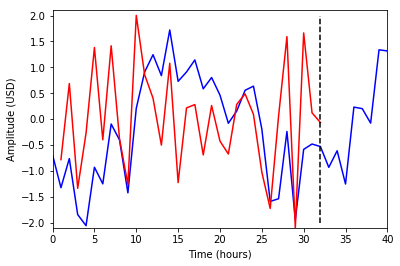

In [137]:
# Display current state
series = (env.prices - np.mean(env.prices)) / np.std(env.prices)
tdiff = series[1:]-series[:-1]
plot_epoch(series);
plot_epoch(np.append(float('NaN'), state.T), color='r');
plt.plot([env.t, env.t], [-2, 2], '--k');
plt.xlim([0, 40]);
plt.ylim([-2.1,2.1]);

"""The red trace is the state observed by the agent, which is the differenciated and normalized price (blue trace)"""

In [138]:
# Act on the environment
""" The agent observe the space up to the vertical dashed bar and picks actions with respect to his belief on the 
price at the next time point"""
action = 4 # Agent selects: long-all (convert all dollars to stock)
next_state, reward, terminated, _ = env.step(action)

In [140]:
# Check return on investment at next step
print('The stock value of the agent moved by %.2f USD' %(reward) )

The stock value of the agent moved by -17.46 USD


# Train an agent

## Agent options

In [148]:
# Let's make a DQN agent
from generic.agents import Agent
agent_opt = {'type': 'DQN', # other choice is DDPG
             'acSpace': len(action_labels),  # how many actions to select from 
             'lr': 1e-3, # learning rate:
             'nz': 'dummy', # no noise on the actions, other choice is OrnsteinUhlenbeck
             'batch_size':16}
agent = Agent(agent_opt['type'], 
              state_size, 
              agent_opt['acSpace'], 
              layer_units=[80, 60],
              noise_process=agent_opt['nz'], 
              learning_rate=agent_opt['lr'],
              batch_size=agent_opt['batch_size'])
agent.p_model = agent.model


In [155]:
# Set visualizer
from src.visualizer import Visualizer
rootStore= open('dbloc.txt', 'r').readline().rstrip('\n')
fld_save = path.join(rootStore, 'results', sampler.title, agent_opt['type'],
            str((env.window_state, sampler.window_episode, agent_opt['batch_size'], agent_opt['lr'],
            agent.discount_factor, wavelet_channels, env.open_cost)))
visualizer= Visualizer(env.action_labels)

In [159]:
# Set the simulator
from src.simulators import Simulator
simulator = Simulator(agent, env, visualizer=visualizer, fld_save=fld_save)
simulator.agent_opt = agent_opt

/home/younesz/.conda/envs/tensorflow_cpu/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "



training...
0	['100+49sin((2pi/21)t)+73e']	79.2	-7.3	39.2	-7.3	39.2	722.8
saving results...


/home/younesz/Documents/Code/DEBUG/deep-RL-time-series-master/src/visualizer.py:86: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  ma = pd.rolling_mean(np.array(explored_total_rewards), window=MA_window, min_periods=1)
/home/younesz/Documents/Code/DEBUG/deep-RL-time-series-master/src/visualizer.py:87: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  std = pd.rolling_std(np.array(explored_total_rewards), window=MA_window, min_periods=3)
/home/younesz/Documents/Code/DEBUG/deep-RL-time-series-master/src/visualizer.py:93: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  ma 	= pd.rolling_mean(safe_total_rewards, window=MA_window, min_periods=1)
/home/younesz/Documents/Code/DEBUG/deep-RL-time-series-master/src/visualizer.py:94: FutureWarning: pd.rolling_std is deprecated for ndarrays and will be removed in a future version
  std = pd.rollin


training...
1	['100+49sin((2pi/27)t)+73e']	78.4	-6.1	13.9	-6.7	26.5	125.6
saving results...

training...
2	['100+49sin((2pi/31)t)+73e']	77.6	2.2	21.5	-6.1	21.5	243.7
saving results...

training...
3	['100+49sin((2pi/20)t)+73e']	76.8	4.1	2.1	-1.9	17.7	24.2
saving results...

training...
4	['100+49sin((2pi/29)t)+73e']	76.1	-3.6	25.4	-3.6	21.5	397.4
saving results...

training...
5	['100+49sin((2pi/36)t)+73e']	75.3	-5.8	20.0	-4.7	20.8	239.0
saving results...

training...
6	['100+49sin((2pi/37)t)+73e']	74.6	-2.5	10.7	-3.6	20.0	114.5
saving results...

training...
7	['100+49sin((2pi/38)t)+73e']	73.8	0.6	28.1	-3.0	20.8	412.9
saving results...

training...
8	['100+49sin((2pi/25)t)+73e']	73.1	-8.0	13.7	-3.6	20.0	286.4
saving results...

training...
9	['100+49sin((2pi/23)t)+73e']	72.4	2.4	28.6	-3.0	20.8	493.9
saving results...

training...
10	['100+49sin((2pi/31)t)+73e']	71.6	8.6	5.2	-0.9	17.0	48.5
saving results...

training...
11	['100+49sin((2pi/30)t)+73e']	70.9	-2.6	34.9	-0.9	20.8	737.5
sa


training...
90	['100+49sin((2pi/32)t)+73e']	32.1	14.8	16.1	11.0	24.5	193.7
saving results...

training...
91	['100+49sin((2pi/24)t)+73e']	31.7	28.2	22.6	11.0	24.5	422.0
saving results...

training...
92	['100+49sin((2pi/24)t)+73e']	31.4	9.7	18.8	10.2	23.4	416.1
saving results...

training...
93	['100+49sin((2pi/39)t)+73e']	31.1	13.4	27.4	11.0	24.5	292.8
saving results...

training...
94	['100+49sin((2pi/35)t)+73e']	30.8	-1.7	25.7	10.4	24.5	418.3
saving results...

training...
95	['100+49sin((2pi/27)t)+73e']	30.5	9.4	24.7	10.4	24.4	255.4
saving results...

training...
96	['100+49sin((2pi/25)t)+73e']	30.2	24.9	30.7	12.2	25.2	861.3
saving results...

training...
97	['100+49sin((2pi/28)t)+73e']	29.9	5.9	30.9	10.4	25.2	343.1
saving results...

training...
98	['100+49sin((2pi/22)t)+73e']	29.6	2.1	3.3	9.5	23.6	62.9
saving results...

training...
99	['100+49sin((2pi/29)t)+73e']	29.3	13.7	20.9	11.5	23.6	358.6
saving results...

training...
100	['100+49sin((2pi/28)t)+73e']	29.0	15.9	21.4	11.5	2


training...
177	['100+49sin((2pi/25)t)+73e']	13.4	20.3	29.9	16.7	25.8	311.4
saving results...

training...
178	['100+49sin((2pi/24)t)+73e']	13.2	-3.3	18.9	14.4	25.8	341.7
saving results...

training...
179	['100+49sin((2pi/31)t)+73e']	13.1	10.3	9.4	14.4	25.8	103.1
saving results...

training...
180	['100+49sin((2pi/37)t)+73e']	13.0	10.9	26.8	14.4	24.4	607.6
saving results...

training...
181	['100+49sin((2pi/37)t)+73e']	12.8	12.2	36.1	12.9	24.4	350.0
saving results...

training...
182	['100+49sin((2pi/29)t)+73e']	12.7	19.8	39.6	12.9	28.3	618.2
saving results...

training...
183	['100+49sin((2pi/20)t)+73e']	12.6	20.6	16.8	15.4	28.3	282.4
saving results...

training...
184	['100+49sin((2pi/29)t)+73e']	12.5	19.5	26.0	19.0	26.4	344.2
saving results...

training...
185	['100+49sin((2pi/29)t)+73e']	12.3	25.6	11.7	19.6	22.4	100.7
saving results...

training...
186	['100+49sin((2pi/31)t)+73e']	12.2	22.9	11.1	19.6	22.4	99.8
saving results...

training...
187	['100+49sin((2pi/36)t)+73e']	12.1	8

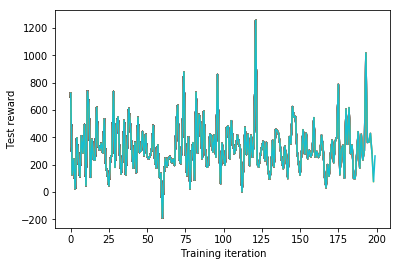

In [161]:
# Train the agent
simulator.train(200, # Number of episodes for training
                save_per_episode=1, # nb of log entries per episode
                exploration_decay=0.99, 
                learning_rate=agent_opt['lr'],
                exploration_min=0.05, 
                print_t=False, 
                exploration_init=0.8);

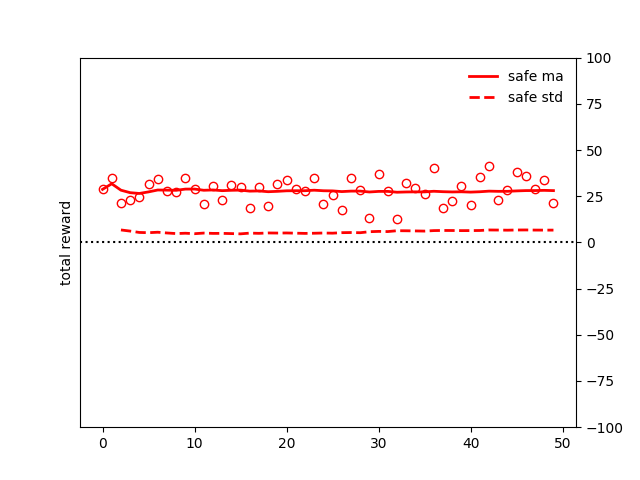

In [169]:
# Visualize testing performance
from IPython.display import Image
img_path = path.join(fld_save, 'in-sample testing', 'total_rewards.png')
Image(filename=img_path)
